여기서는 이미지를 openCV를 활용하여 자르고, 정확한 bbox를 구한다.</br>
그 뒤, 각 이미지마다 bbox 기준으로 자른 후 224x224 크기의 투명 이미지의 중앙에 합성하여 분류기용 이미지로 만든다.</br>
분류기용 이미지들을 해당하는 폴더들로 수작업으로 분류해준다.</br>
</br>
분류가 완료되면 2가지 작업을 수행한다.

- 분류기에 넣을 dataset으로 만들어서 사전학습된 분류기를 학습시킨다.
- 이미 주어진 annotation 파일을 활용하여 bbox 값을 수정하거나, 라벨링이 없는 데이터들에 대해 bbox를 추가하여 annotation을 만들어준다.

여기서는 2가지 가정을 한다.

- 학습 데이터로 주어지는 이미지에서, 모든 알약은 충분한 간격을 두고 떨어져 있으며, 가로로 두 구역으로 나눌 때 두 구역 사이에는 충분한 간격이 있다.
- 이 파일에서 사용하는 모든 이미지는 배경이 제거되어 있는 것을 사용한다.

In [8]:
import os
import json
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import operator
import pandas as pd
import copy

# 이미지 자르기
가장 먼저, 각 이미지마다 3~4개의 이미지로 나눠준다.</br>
자른 뒤, 원본 이미지의 크기와 각 이미지가 원본에서 어느 범위에 해당하는지를 텍스트 파일로 저장한다.</br>
아래의 변환 함수는 [링크](https://dreamfuture.tistory.com/50)의 블로그 글을 차용하였다.

In [9]:
def PIL2OpenCV(pil_image):
    numpy_image= np.array(pil_image)
    opencv_image = cv2.cvtColor(numpy_image, cv2.COLOR_RGB2BGR)
    return opencv_image

def OpenCV2PIL(opencv_image):
    color_coverted = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(color_coverted)
    return pil_image

In [14]:
def image_cutter(images_path='./ai06-level1-project/train_output',annotations_path='./ai06-level1-project/train_annotations'):
    images=sorted(os.listdir(images_path))
    annotations=sorted(os.listdir(annotations_path))

    count=0
    for image in images:
        count+=1
        print(count)
        # 알약 조합은 이름에서 확장자 및 이미지 정보를 제거한 것과 같다.
        name=image[:-23]

        # 만약 annotation에 해당 알약 조합의 정보가 없다면, 폴더를 만들어준다.
        if not os.path.isdir(annotations_path,name+"_json"):
            os.makedirs(annotations_path,name+"_json")

        # 이미지 파일을 불러온다.
        image_file=Image.open(os.path.join(images_path,image))

        # 이미지 파일을 cv 파일로, 배경을 유지하여 만들어준다.
        image_cv=cv2.cvtColor(np.array(image_file), cv2.COLOR_RGBA2BGRA)

        # 이미지 파일을 cv 파일로, 배경을 지워서 만들어준다.
        image_file=PIL2OpenCV(image_file.convert("RGB"))

        # 이미지 파일에 변형을 가할 파일을 만들어준다.
        conv_file=np.zeros_like(image_file)

        # 이미지 파일 원본의 크기를 구한다.
        H,W,C=image_file.shape

        # 각 칸에 대해, 배경에 해당하면 흰색, 아니면 검은 색으로 만들어준다.
        conv_file[(image_file==[130,130,130]).all(axis=2)]=255
        
        # 검출된 3~4개의 이미지를 저장할 배열이다.
        imgs=[]

        # 행 단위로 (horizontal) 직전 행의 모든 칸이 흰색인지 체크한다.
        check_h=True
        h_line=[]
        for h in range(H):
            # 이번 행에서 모든 칸이 흰색인가에 대해서
            cur_row=(conv_file[h]==255).all()
            # 만약 cur_row와 check_h가 서로 다르다면 h_line에 추가
            if check_h != cur_row:
                if len(h_line)>0:
                    if h_line[-1]+50>h:
                        continue
                h_line.append(h)
                check_h=cur_row
        # 객체가 테두리에 맞닿아 있거나, 테두리에 의해 잘린 경우가 있다.
        if len(h_line)%2==1:
            h_line.append(H-1)
        # 행 단위로 나누는 선을 만든다.
        h_line=[h_line[0]//2,(h_line[1]+h_line[2])//2,((h_line[3]+H)//2)]

        # 행 단위로 2개의 파트를 만든다.
        conv1=conv_file[h_line[0]+1:h_line[1]+1]
        conv2=conv_file[h_line[1]+1:h_line[2]+1]

        # 파트 1의 이미지 수를 구한다.
        check_v=True
        v_line1=[]
        for w in range(W):
            # 이번 열에서 파트 1의 모든 칸이 흰색인가에 대해서
            cur_col=(conv1[:,w]==255).all()
            # 만약 cur_col과 check_v가 서로 다르다면 v_line1에 추가
            if check_v != cur_col:
                if len(v_line1)>0:
                    if v_line1[-1]+50>w:
                        continue
                v_line1.append(w)
                check_v=cur_col
        # 객체가 테두리에 맞닿아 있거나, 테두리에 의해 잘린 경우가 있다.
        if len(v_line1)%2==1:
            v_line1.append(W-1)
        # v_line1의 길이가 4라면, imgs에 2개의 이미지를 넣어준다.
        if len(v_line1)==4:
            v_line1=[v_line1[0]//2,(v_line1[1]+v_line1[2])//2,((v_line1[3]+W)//2)]
            imgs.append(image_cv[h_line[0]:h_line[1],v_line1[0]:v_line1[1]])
            imgs.append(image_cv[h_line[0]:h_line[1],v_line1[1]:v_line1[2]])
        # 아니라면 imgs에는 1개의 이미지가 추가된다.
        else:
            v_center=sum(v_line1)//2
            v_line1=[max(0,v_center-256),min(W,v_center+256)]
            imgs.append(image_cv[h_line[0]:h_line[1],v_line1[0]:v_line1[1]])

        # 파트 2에 대해서도 마찬가지로 한다.
        check_v2=True
        v_line2=[]
        for w in range(W):
            cur_col2=(conv2[:,w]==255).all()
            # 만약 cur_col과 check_v가 서로 다르다면 v_line2에 추가
            if check_v2 != cur_col2:
                if len(v_line2)>0:
                    if v_line2[-1]+50>w:
                        continue
                v_line2.append(w)
                check_v2=cur_col2
        # 객체가 테두리에 맞닿아 있거나, 테두리에 의해 잘린 경우가 있다.
        if len(v_line2)%2==1:
            v_line2.append(W-1)
        # v_line2의 길이가 4라면, imgs에 2개의 이미지를 넣어준다.
        if len(v_line2)==4:
            v_line2=[v_line2[0]//2,(v_line2[1]+v_line2[2])//2,((v_line2[3]+W)//2)]
            imgs.append(image_cv[h_line[1]:h_line[2],v_line2[0]:v_line2[1]])
            imgs.append(image_cv[h_line[1]:h_line[2],v_line2[1]:v_line2[2]])
        # 아니라면 imgs에는 1개의 이미지가 추가된다.
        else:
            v_center=sum(v_line2)//2
            v_line2=[max(0,v_center-256),min(W,v_center+256)]
            imgs.append(image_cv[h_line[1]:h_line[2],v_line2[0]:v_line2[1]])

        # imgs의 각 이미지를 폴더에 저장해준다.
        for idx,img in enumerate(imgs):
            image_i=Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA))
            image_i.save(f"./cropped_images/{image[:-4]}_{str(idx+1)}.png", format="PNG")

        # 이미지 정보를 txt로 저장한다.
        with open(f'{annotations_path}/{name}_json/{image[:-4]}.txt','w') as f:
            f.write(f'H: {H}\n')
            f.write(f'W: {W}\n')
            cnt=0
            # 만약 파트 1의 이미지가 2개라면
            if len(v_line1)==3:
                f.write(f'img{str(cnt+1)}: {h_line[0]},{h_line[1]},{v_line1[0]},{v_line1[1]}\n')
                f.write(f'img{str(cnt+2)}: {h_line[0]},{h_line[1]},{v_line1[1]},{v_line1[2]}\n')
                cnt+=2
            else:
                f.write(f'img{str(cnt+1)}: {h_line[0]},{h_line[1]},{v_line1[0]},{v_line1[1]}\n')
                cnt+=1
            # 만약 파트 2의 이미지가 2개라면
            if len(v_line2)==3:
                f.write(f'img{str(cnt+1)}: {h_line[1]},{h_line[2]},{v_line2[0]},{v_line2[1]}\n')
                f.write(f'img{str(cnt+2)}: {h_line[1]},{h_line[2]},{v_line2[1]},{v_line2[2]}\n')
                cnt+=2
            else:
                f.write(f'img{str(cnt+1)}: {h_line[1]},{h_line[2]},{v_line2[0]},{v_line2[1]}\n')
                cnt+=1

image_cutter(images_path='./ai06-level1-project/train_output',annotations_path='./ai06-level1-project/train_annotations')

1


TypeError: isdir() takes 1 positional argument but 2 were given

이로써, 각 annotation 폴더는 하나의 '알약 조합'에 대한 여러 이미지들의 설명 파일을 갖게 된다.</br>
각 설명 파일의 처음 2줄은 원본 이미지의 크기이다.</br>
이후, 3~4개의 세부 이미지에 대해 그 이미지들의 원본(전체)이미지에서의 위치를 x1,x2,y1,y2로 갖는다.

# 상세 bbox 구하기
이제 각 상세 이미지마다 bbox를 구한다.</br>
이 과정에서의 bbox 정보는 동일한 위치에, 새로운 txt 파일로 저장한다.

In [15]:
def bbox_detect(annotation_root='./ai06-level1-project/train_annotations', image_root='./ai06-level1-project/train_output'):
    # 각 이미지 정보 폴더를 순회한다.
    annotations=sorted(os.listdir(annotation_root))

    cnt=0

    for annotation in annotations:
        # txt 파일들 목록을 불러온다.
        image_info=copy.deepcopy([entry.name for entry in os.scandir(os.path.join(annotation_root,annotation)) if entry.is_file() and entry.name.endswith(".txt")])
        
        # 이미지 하나에 대한 txt 파일마다
        for sub_info in image_info:
            if 'bbox' in sub_info:
                continue
            print(cnt+1)
            cnt+=1
            
            image_name=sub_info[:-4]
            # 이미지 이름은 sub_info에서 마지막 확장자를 지운 것과 같다.
            image=Image.open(os.path.join(image_root,image_name+'.png'))

            # 이미지 파일을 cv 파일로, 배경을 유지하여 만들어준다.
            image_cv=cv2.cvtColor(np.array(image), cv2.COLOR_RGBA2BGRA)

            # 이미지 파일을 cv 파일로, 배경을 지워서 만들어준다.
            image_file=PIL2OpenCV(image.convert("RGB"))

            # 이미지 파일에 변형을 가할 파일을 만들어준다.
            conv_file=np.zeros_like(image_file)

            # 이미지 파일 원본의 크기를 구한다.
            H,W,C=image_file.shape

            # 각 칸에 대해, 배경에 해당하면 흰색, 아니면 검은 색으로 만들어준다.
            conv_file[(image_file==[130,130,130]).all(axis=2)]=255

            with open(os.path.join(annotation_root,annotation,sub_info),'r') as f:
                # 이미지의 높이, 너비 정보를 얻는다.
                H=f.readline().strip()[3:]
                W=f.readline().strip()[3:]
                parts=f.readlines()

                h_line=[]
                v_line=[]
                
                for part in parts:
                    part=part.strip().split()
                    part_num=part[0][3:-1]
                    y1,y2,x1,x2=map(int,part[1].split(','))

                    # 현재 부분 이미지에서 수평선 기준으로 상하 경계선을 구한다.
                    check=True
                    # 최외곽 픽셀을 기준으로 경계선을 구하기 위함이다.
                    h_dot=[]
                    for y in range(y1,y2):
                        cur_check=(conv_file[y,x1:x2]==255).all()
                        if check != cur_check:
                            h_dot.append(y)
                        check=cur_check
                        if len(h_dot) == 1:
                            h_dot.append(x2)

                    # 현재 부분 이미지에서 수직선 기준으로 좌우 경계선을 구한다.
                    check=True
                    # 최외곽 픽셀을 기준으로 경계선을 구하기 위함이다.
                    v_dot=[]
                    for x in range(x1,x2):
                        cur_check=(conv_file[y1:y2,x]==255).all()
                        if check != cur_check:
                            v_dot.append(x)
                        check=cur_check
                        if len(v_dot) == 1:
                            v_dot.append(y2)
                        
                    # 앞서 구한 픽셀들 중 첫 픽셀과 마지막 픽셀을 활용한다.
                    h_line.append(h_dot[0])
                    h_line.append(h_dot[-1])
                    v_line.append(v_dot[0])
                    v_line.append(v_dot[-1])
                
                # 전체 부분 이미지에 대해 bbox를 저장할 파일을 연다.
                with open(os.path.join(annotation_root,annotation,image_name+'_bbox.txt'),'w') as f:
                    f.write('id\ty1\ty2\tx1\tx2\n')
                    # 각 부분 이미지마다 세부 bbox를 저장한다.
                    for p in range(len(parts)):
                        f.write(f'img{str(p+1)}: {h_line[p*2]},{h_line[p*2+1]},{v_line[p*2]},{v_line[p*2+1]}\n')

bbox_detect(annotation_root='./ai06-level1-project/train_annotations', image_root='./ai06-level1-project/train_output')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


# 이미지 저장 및 라벨링하기
이제 각 객체 단위로 이미지를 자른 후, 빈 배경의 256 x 256 이미지의 중앙에 합성한다.

In [16]:
def image_crop_with_bbox(annotation_root='./ai06-level1-project/train_annotations',image_root='./ai06-level1-project/train_output',crop_path='./cropped_images/'):
    # 각 이미지 정보 폴더를 순회한다.

    annotations=sorted(os.listdir(annotation_root))

    cnt=0

    for annotation in annotations:
        # txt 파일들 목록을 불러온다.
        image_info=copy.deepcopy([entry.name for entry in os.scandir(os.path.join(annotation_root,annotation)) if entry.is_file() and entry.name.endswith(".txt")])
        
        # 이미지 하나에 대한 txt 파일마다
        for sub_info in image_info:
            if 'bbox' not in sub_info:
                continue
            print(cnt+1)
            cnt+=1
            
            image_name=sub_info[:-4]
            # 이미지 이름은 sub_info에서 마지막 확장자를 지운 것과 같다.
            image=Image.open(os.path.join(image_root,image_name[:-5]+'.png'))

            # 이미지 파일을 cv 파일로, 배경을 유지하여 만들어준다.
            image_cv=cv2.cvtColor(np.array(image), cv2.COLOR_RGBA2BGRA)

            # 이미지 파일을 cv 파일로, 배경을 지워서 만들어준다.
            image_file=PIL2OpenCV(image.convert("RGB"))

            # 이미지 파일 원본의 크기를 구한다.
            H,W,C=image_file.shape

            with open(os.path.join(annotation_root,annotation,sub_info),'r') as f:
                f.readline()
                # 이미지의 높이, 너비 정보를 얻는다.
                parts=f.readlines()
                
                # 각 세부 이미지마다
                for part in parts:
                    part=part.strip().split()
                    # id와 좌표를 얻는다.
                    part_id=part[0][3:-1]
                    y1,y2,x1,x2=map(int,part[1].split(','))
                    # 배경을 유지한 이미지에서 세부 이미지를 잘라낸다.
                    img=image_cv[y1:y2,x1:x2]
                    img=Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA))
                    
                    # 크기 640x640의 투명 배경인 빈 이미지를 만든다.
                    canvas_size = (640,640)
                    canvas = Image.new("RGBA", canvas_size, (0,0,0,0))

                    h,w=y2-y1,x2-x1
                    x=(640-w)//2
                    y=(640-h)//2
                    canvas.paste(img,(x,y),img)
                    canvas.save(os.path.join(crop_path,image_name[:-4]+part_id+'.png'))

image_crop_with_bbox(annotation_root='./ai06-level1-project/train_annotations',image_root='./ai06-level1-project/train_output',crop_path='./cropped_images/')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


테스트용 코드입니다.</br>
적절히 좌표 및 이미지 이름을 넣어서 사용하세요.</br>
상자 이미지가 잘 보이도록 출력물에서 알파 채널을 지웠습니다.

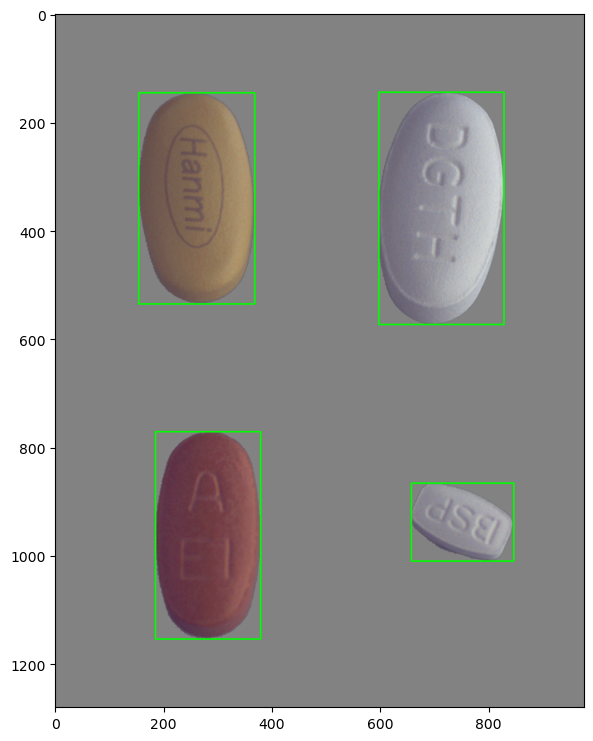

In [29]:
image_root='./ai06-level1-project/train_output'
image_name='K-001900-010224-016551-031705_0_2_0_2_70_000_200'
image=Image.open(os.path.join(image_root,image_name+'.png'))
image_cv=cv2.cvtColor(np.array(image), cv2.COLOR_RGBA2BGR)
pt1 = (154, 145)
pt2 = (368, 535)
cv2.rectangle(image_cv, pt1, pt2, (0, 256, 0), 2)
pt3 = (597, 144)
pt4 = (828, 573)
cv2.rectangle(image_cv, pt3, pt4, (0, 256, 0), 2)
pt5 = (185, 771)
pt6 = (379, 1154)
cv2.rectangle(image_cv, pt5, pt6, (0, 256, 0), 2)
pt7 = (657, 866)
pt8 = (846, 1010)
cv2.rectangle(image_cv, pt7, pt8, (0, 256, 0), 2)

fig, ax = plt.subplots(1, figsize=(12,9))
plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_RGB2BGR))
plt.show()

In [34]:
max_width,max_height

(473, 592)

# 분류기 학습 및 예측하기
각 이미지 조각에 대해, 분류기를 통해 학습을 시킨다.</br>
학습이 완료되면, 앞서 train 데이터에 적용한 방법을 사용하여 test 데이터를 생성한다.</br>
분류기를 통해, test 데이터의 이미지들에 대해 분류를 수행한다.

In [ ]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import torch.nn as nn

num_classes = 56

이제 데이터셋을 준비한다.

In [5]:
annotation_root='./ai06-level1-project/train_annotations'
annotations=sorted(os.listdir(annotation_root))

image_root='./ai06-level1-project/train_output'

code=[]
images = os.listdir(image_root)
for i in images:
    i=i[2:-23]
    codes=list(map(int,i.split('-')))
    code.extend(codes)

code=sorted(list(set(code)))
code

[1900,
 2483,
 3351,
 3483,
 3544,
 3743,
 3832,
 4378,
 4543,
 5094,
 5886,
 6192,
 6563,
 10221,
 10224,
 12081,
 12247,
 12420,
 12778,
 13395,
 13900,
 16232,
 16262,
 16548,
 16551,
 16688,
 18110,
 18147,
 18357,
 19232,
 19552,
 19607,
 19861,
 20014,
 20238,
 20877,
 21026,
 21325,
 21771,
 22074,
 22347,
 22362,
 22627,
 23203,
 23223,
 24850,
 25367,
 25438,
 25469,
 27653,
 27733,
 27777,
 27926,
 27993,
 28763,
 29345,
 29451,
 29667,
 29871,
 30308,
 31705,
 31863,
 31885,
 32310,
 33009,
 33208,
 33878,
 33880,
 34597,
 35206,
 36637,
 38162,
 41768,
 44199]

In [6]:
len(code)

74

그리고, 모델을 준비해준다.

In [ ]:
# 백본만 사전학습된 상태로 로드
model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

# 분류기 헤드 교체
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)

# YOLO 학습하기
앞서 만들었던 bbox 데이터를 활용하여 YOLO 학습용 annotation 파일들을 만든다.</br>
그 파일들을 이용하여 YOLO 학습용 dataset을 만든 뒤 적용한다.